In [8]:
!pip install boto3
!pip install boto3 geopandas matplotlib fiona pyproj shapely rtree


                                    fault_name section_na fault_id section_id  \
0  Goose Lake graben faults (Goose Lake fault)       None      828       None   
1  Goose Lake graben faults (Goose Lake fault)       None      828       None   
2  Goose Lake graben faults (Goose Lake fault)       None      828       None   
3  Goose Lake graben faults (Goose Lake fault)       None      828       None   
4  Goose Lake graben faults (Goose Lake fault)       None      828       None   

     Location          linetype              age dip_direct  \
0  California  Well Constrained  late Quaternary          W   
1  California  Well Constrained  late Quaternary          W   
2  California  Well Constrained  late Quaternary          W   
3  California  Well Constrained  late Quaternary          W   
4  California  Well Constrained  late Quaternary          W   

             slip_rate slip_sense  ... strike fault_leng  \
0  Less than 0.2 mm/yr     Normal  ...   None          0   
1  Less than 0

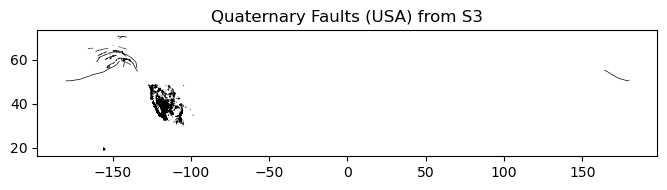

In [9]:
import boto3
import geopandas as gpd
import matplotlib.pyplot as plt
import tempfile
import os


s3 = boto3.client("s3")


bucket_name = "airlinessss"
shapefile_prefix = "faults/Qfaults_US_Database"  


tmp_dir = tempfile.mkdtemp()


for ext in [".shp", ".shx", ".dbf", ".prj"]:
    key = shapefile_prefix + ext
    local_path = os.path.join(tmp_dir, os.path.basename(key))
    obj = s3.get_object(Bucket=bucket_name, Key=key)
    with open(local_path, "wb") as f:
        f.write(obj["Body"].read())


shp_local = os.path.join(tmp_dir, "Qfaults_US_Database.shp")
gdf = gpd.read_file(shp_local)


print(gdf.head())
fig, ax = plt.subplots(figsize=(8, 8))
gdf.plot(ax=ax, linewidth=0.5, edgecolor="black")
ax.set_title("Quaternary Faults (USA) from S3")
plt.show()


In [10]:

print("Satır × Sütun:", gdf.shape)


print("Sütunlar:", gdf.columns.tolist())


Satır × Sütun: (112809, 23)
Sütunlar: ['fault_name', 'section_na', 'fault_id', 'section_id', 'Location', 'linetype', 'age', 'dip_direct', 'slip_rate', 'slip_sense', 'scale', 'class', 'certainty', 'strike', 'fault_leng', 'cooperator', 'earthquake', 'review_dat', 'fault_url', 'symbology', 'ref_id', 'Shape_Leng', 'geometry']


In [11]:
pip install openpyxl boto3


Note: you may need to restart the kernel to use updated packages.


In [12]:
import boto3
import pandas as pd
import io


s3 = boto3.client("s3")


bucket_name = "airlinessss"
file_key    = "yeni(Sayfa1).xlsx"   


obj = s3.get_object(Bucket=bucket_name, Key=file_key)


df = pd.read_excel(io.BytesIO(obj["Body"].read()), engine="openpyxl")


print("Satır × Sütun:", df.shape)
print("\nSütunlar:")
for col in df.columns:
    print(" -", col)
print("\nİlk 5 Kayıt:")
print(df.head())


Satır × Sütun: (335708, 14)

Sütunlar:
 - radio
 - mcc
 - net
 - area
 - cell
 - unit
 - lon
 - lat
 - range
 - samples
 - changeable
 - created
 - updated
 - averageSignal

İlk 5 Kayıt:
  radio  mcc  net   area   cell  unit       lon      lat  range  samples  \
0   GSM  310  260  51051  44473     0  -71.1100  42.3588   1033       19   
1   GSM  310  260  39473  35051     0  -90.1889  38.5571   2892        3   
2   GSM  310  260     14  33881     0 -118.4972  34.0106   5506       12   
3   GSM  310  260    357  44662     0 -121.9716  41.8830  14197      107   
4   GSM  310  260    307  17022     0 -120.2441  36.2024  11840        8   

   changeable     created     updated  averageSignal  
0           1  1459813819  1745016670            0.1  
1           1  1459810861  1714663622            0.0  
2           1  1343770116  1741492750            0.0  
3           1  1352082563  1704351241            0.0  
4           1  1363987473  1718156042            0.0  


In [13]:

!pip install boto3

import boto3
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
import tempfile
import os
import io


s3 = boto3.client("s3")
bucket_name = "airlinessss"


shp_prefix = "faults/Qfaults_US_Database"  
excel_key = "yeni(Sayfa1).xlsx"


tmp_dir = tempfile.mkdtemp()
for ext in [".shp", ".shx", ".dbf", ".prj"]:
    key = shp_prefix + ext
    local_path = os.path.join(tmp_dir, os.path.basename(key))
    resp = s3.get_object(Bucket=bucket_name, Key=key)
    with open(local_path, "wb") as f:
        f.write(resp["Body"].read())


shp_local = os.path.join(tmp_dir, "Qfaults_US_Database.shp")
faults_gdf = gpd.read_file(shp_local)[['fault_id','age','class','slip_rate','geometry']]


resp_xlsx = s3.get_object(Bucket=bucket_name, Key=excel_key)
base_df = pd.read_excel(io.BytesIO(resp_xlsx["Body"].read()))


base_gdf = gpd.GeoDataFrame(
    base_df,
    geometry=[Point(xy) for xy in zip(base_df.lon, base_df.lat)],
    crs="EPSG:4326"
)


faults_proj = faults_gdf.to_crs(epsg=3857)
base_proj   = base_gdf.to_crs(epsg=3857)


joined_proj = gpd.sjoin_nearest(
    base_proj,
    faults_proj,
    how="left",
    distance_col="dist_to_fault"
)
joined_proj = joined_proj[~joined_proj.index.duplicated()]


joined = joined_proj.to_crs(epsg=4326)


print("Satır × Sütun:", joined.shape)
print(joined[['cell','lon','lat','fault_id','age','class','slip_rate','dist_to_fault']].head())


Satır × Sütun: (335708, 21)
    cell       lon      lat fault_id                age class  \
0  44473  -71.1100  42.3588     1031  latest Quaternary     A   
1  35051  -90.1889  38.5571     1031  latest Quaternary     A   
2  33881 -118.4972  34.0106      101    late Quaternary     A   
3  44662 -121.9716  41.8830        2  latest Quaternary     A   
4  17022 -120.2441  36.2024       28           historic     A   

                   slip_rate  dist_to_fault  
0        Less than 0.2 mm/yr   3.216092e+06  
1        Less than 0.2 mm/yr   1.047918e+06  
2  Between 1.0 and 5.0 mm/yr   2.602412e+03  
3  Between 0.2 and 1.0 mm/yr   5.163769e+02  
4  Between 1.0 and 5.0 mm/yr   5.344579e+03  


In [14]:

print("Satır × Sütun:", joined.shape)


print("\nSütunlar:")
for col in joined.columns:
    print(" -", col)


print("\nVeri Tipleri:")
print(joined.dtypes)


print("\nDataFrame Bilgisi:")
joined.info()


print("\nSayısal Sütun İstatistikleri:")
print(joined.describe())


print("\nİlk 5 Kayıt:")
print(joined.head())


Satır × Sütun: (335708, 21)

Sütunlar:
 - radio
 - mcc
 - net
 - area
 - cell
 - unit
 - lon
 - lat
 - range
 - samples
 - changeable
 - created
 - updated
 - averageSignal
 - geometry
 - index_right
 - fault_id
 - age
 - class
 - slip_rate
 - dist_to_fault

Veri Tipleri:
radio              object
mcc                 int64
net                 int64
area                int64
cell                int64
unit                int64
lon               float64
lat               float64
range               int64
samples             int64
changeable          int64
created             int64
updated             int64
averageSignal     float64
geometry         geometry
index_right         int64
fault_id           object
age                object
class              object
slip_rate          object
dist_to_fault     float64
dtype: object

DataFrame Bilgisi:
<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 335708 entries, 0 to 335707
Data columns (total 21 columns):
 #   Column         Non-Null Coun

In [15]:
import boto3
import pandas as pd
import io
import os


bucket_name = "airlinessss"
file_key    = "filtered_population_density.csv"  


s3 = boto3.client("s3")
obj = s3.get_object(Bucket=bucket_name, Key=file_key)
data = obj["Body"].read()


ext = os.path.splitext(file_key)[1].lower()
if ext == ".csv":
    df = pd.read_csv(io.BytesIO(data), encoding="latin1")
elif ext in [".xls", ".xlsx"]:
    df = pd.read_excel(io.BytesIO(data))
else:
    raise ValueError(f"Desteklenmeyen uzantı: {ext}")


print("Satır × Sütun:", df.shape)


print("\nSütunlar:")
for col in df.columns:
    print(" -", col)


print("\nVeri Tipleri:")
print(df.dtypes)


print("\nDataFrame Bilgisi:")
df.info()


print("\nSayısal Sütun İstatistikleri:")
print(df.describe())


print("\nİlk 5 Kayıt:")
print(df.head())


Satır × Sütun: (9527155, 3)

Sütunlar:
 - X
 - Y
 - Z

Veri Tipleri:
X    float64
Y    float64
Z    float64
dtype: object

DataFrame Bilgisi:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9527155 entries, 0 to 9527154
Data columns (total 3 columns):
 #   Column  Dtype  
---  ------  -----  
 0   X       float64
 1   Y       float64
 2   Z       float64
dtypes: float64(3)
memory usage: 218.1 MB

Sayısal Sütun İstatistikleri:
                  X             Y             Z
count  9.527155e+06  9.527155e+06  9.527155e+06
mean  -1.021239e+02  4.195225e+01  5.162171e+01
std    2.071641e+01  9.060402e+00  3.363736e+02
min   -1.766804e+02  1.892042e+01  5.300904e-10
25%   -1.111637e+02  3.577875e+01  6.040569e-02
50%   -9.753042e+01  4.055375e+01  9.825272e-01
75%   -8.773042e+01  4.526208e+01  8.526480e+00
max    1.741529e+02  7.133708e+01  6.459127e+04

İlk 5 Kayıt:
            X          Y           Z
0 -156.613749  71.337083    1.924609
1 -156.605416  71.337083    3.926429
2 -156.6887

In [16]:

print("\nSayısal Sütun İstatistikleri:")
print(df.describe())


Sayısal Sütun İstatistikleri:
                  X             Y             Z
count  9.527155e+06  9.527155e+06  9.527155e+06
mean  -1.021239e+02  4.195225e+01  5.162171e+01
std    2.071641e+01  9.060402e+00  3.363736e+02
min   -1.766804e+02  1.892042e+01  5.300904e-10
25%   -1.111637e+02  3.577875e+01  6.040569e-02
50%   -9.753042e+01  4.055375e+01  9.825272e-01
75%   -8.773042e+01  4.526208e+01  8.526480e+00
max    1.741529e+02  7.133708e+01  6.459127e+04


In [17]:

!pip install boto3

import boto3
import pandas as pd
import geopandas as gpd
import io
from shapely.geometry import Point


bucket_name = "airlinessss"
file_key    = "filtered_population_density.csv"


s3 = boto3.client("s3")
obj = s3.get_object(Bucket=bucket_name, Key=file_key)
pop_df = pd.read_csv(io.BytesIO(obj['Body'].read()), encoding="latin1")


pop_gdf = gpd.GeoDataFrame(
    pop_df,
    geometry=gpd.points_from_xy(pop_df.X, pop_df.Y),
    crs="EPSG:4326"
)

# 5. Hem nüfus hem baz istasyonu + fay GeoDataFrame'lerini metre cinsine dönüştürün
pop_proj    = pop_gdf.to_crs(epsg=3857)
joined_proj = joined.to_crs(epsg=3857)

# 6. Önceki 'index_right' varsa kaldırın
if 'index_right' in joined_proj.columns:
    joined_proj = joined_proj.drop(columns=['index_right'])

# 7. Spatial join ile en yakın nüfus noktasını ve mesafeyi ekleyin
joined_pop = gpd.sjoin_nearest(
    joined_proj,
    pop_proj[['Z', 'geometry']],
    how="left",
    distance_col="pop_dist"
)

# 8. Tekilleştirip coğrafi CRS'e geri dönün
joined_pop = joined_pop[~joined_pop.index.duplicated()].to_crs(epsg=4326)

# 9. 'Z' sütununu 'pop_density' olarak yeniden adlandırın
joined_pop = joined_pop.rename(columns={'Z': 'pop_density'})

# 10. Sonucu kontrol edin
print("Satır × Sütun:", joined_pop.shape)
print(joined_pop[['cell','lon','lat','pop_density','pop_dist']].head())


Satır × Sütun: (335708, 23)
    cell       lon      lat  pop_density    pop_dist
0  44473  -71.1100  42.3588  8509.738281  647.230216
1  35051  -90.1889  38.5571    70.379494  477.167306
2  33881 -118.4972  34.0106  1611.094116  199.633523
3  44662 -121.9716  41.8830     0.481220  612.924466
4  17022 -120.2441  36.2024     0.513798  380.716209


In [18]:
print(joined_pop.columns.tolist())


['radio', 'mcc', 'net', 'area', 'cell', 'unit', 'lon', 'lat', 'range', 'samples', 'changeable', 'created', 'updated', 'averageSignal', 'geometry', 'fault_id', 'age', 'class', 'slip_rate', 'dist_to_fault', 'index_right', 'pop_density', 'pop_dist']


In [19]:
# Satır × Sütun sayısı
print("Satır × Sütun:", joined_pop.shape)

# Veri tipleri ve null sayılarıyla genel bilgi
print("\n--- joined_pop.info() ---")
joined_pop.info(show_counts=True)

# Sayısal sütunlar için özet istatistikler
print("\n--- Sayısal Sütun İstatistikleri ---")
print(joined_pop.describe())

# Kategorik (object) sütunlar için özet istatistikler
print("\n--- Kategorik Sütun İstatistikleri ---")
print(joined_pop.describe(include=["object"]))


Satır × Sütun: (335708, 23)

--- joined_pop.info() ---
<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 335708 entries, 0 to 335707
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype   
---  ------         --------------   -----   
 0   radio          335708 non-null  object  
 1   mcc            335708 non-null  int64   
 2   net            335708 non-null  int64   
 3   area           335708 non-null  int64   
 4   cell           335708 non-null  int64   
 5   unit           335708 non-null  int64   
 6   lon            335708 non-null  float64 
 7   lat            335708 non-null  float64 
 8   range          335708 non-null  int64   
 9   samples        335708 non-null  int64   
 10  changeable     335708 non-null  int64   
 11  created        335708 non-null  int64   
 12  updated        335708 non-null  int64   
 13  averageSignal  335708 non-null  float64 
 14  geometry       335708 non-null  geometry
 15  fault_id       335708 non-null  object  
 16

In [20]:
# joined_pop GeoDataFrame’inizin yüklü olduğunu varsayıyoruz

# 1) Eşikleri ayarla
pd_q70 = joined_pop['pop_density'].quantile(0.70)   # üst %30
max_dist = 1000                                     # 1 km

# 2) Risk filtresi
risk = joined_pop[
    (joined_pop['pop_density'] >= pd_q70) |         # yoğun nüfuslu
    (joined_pop['dist_to_fault'] < max_dist)        # faya <1 km
].copy()

# 3) Sonuç kontrolü
print("Filtrelenmiş satır sayısı:", risk.shape[0])
print("İlk 5 satır:")
print(risk[['cell', 'pop_density', 'dist_to_fault']].head())


Filtrelenmiş satır sayısı: 108195
İlk 5 satır:
         cell   pop_density  dist_to_fault
0       44473   8509.738281   3.216092e+06
2       33881   1611.094116   2.602412e+03
3       44662      0.481220   5.163769e+02
12  166736657  13855.543945   2.437193e+06
13  166736655  13855.543945   2.437439e+06


In [21]:
# Satır × Sütun sayısı
print("Satır × Sütun:", risk.shape[0])

Satır × Sütun: 108195


In [22]:
# ---------------------------------------------------------------
# 1) RADIO sütunu: kaç sınıf ve one-hot
# ---------------------------------------------------------------
print("Farklı radio teknolojisi sayısı (risk):", risk['radio'].nunique())
print("\nRadio dağılımı (risk):")
print(risk['radio'].value_counts())

radio_dum = pd.get_dummies(risk['radio'], prefix='tech')
risk = pd.concat([risk.drop(columns=['radio']), radio_dum], axis=1)

print("\nYeni tech_* sütunları (ilk 3 satır):")
print(risk.filter(like='tech_').head(3))

# ---------------------------------------------------------------
# 2) fault_id sütunu: frekans kodu ve Top-5 bayrakları
# ---------------------------------------------------------------
# a. Segment frekansını sadece risk tablosunda hesapla
seg_freq_risk = risk['fault_id'].value_counts(normalize=True)
risk['fault_freq'] = risk['fault_id'].map(seg_freq_risk)

# b. En yaygın 5 segment için bayrak sütunları
top_ids = seg_freq_risk.head(5).index
for fid in top_ids:
    risk[f'fid_{fid}'] = (risk['fault_id'] == fid).astype(int)

# c. Diğer segmentler için tek bayrak
risk['other_fault'] = (~risk['fault_id'].isin(top_ids)).astype(int)

print("\nTop-5 fault bayrakları ve fault_freq (ilk 3 satır):")
cols = ['fault_id', 'fault_freq'] + [f'fid_{fid}' for fid in top_ids] + ['other_fault']
print(risk[cols].head(3))

# ---------------------------------------------------------------
# Son tablo boyutu ve sütun sayısı
print("\nRisk tablosu boyutu:", risk.shape)


Farklı radio teknolojisi sayısı (risk): 4

Radio dağılımı (risk):
radio
LTE     84919
NR      19234
GSM      2677
UMTS     1365
Name: count, dtype: int64

Yeni tech_* sütunları (ilk 3 satır):
   tech_GSM  tech_LTE  tech_NR  tech_UMTS
0      True     False    False      False
2      True     False    False      False
3      True     False    False      False

Top-5 fault bayrakları ve fault_freq (ilk 3 satır):
  fault_id  fault_freq  fid_1031  fid_1032  fid_55  fid_461  fid_127  \
0     1031    0.596636         1         0       0        0        0   
2      101    0.001765         0         0       0        0        0   
3        2    0.000018         0         0       0        0        0   

   other_fault  
0            0  
2            1  
3            1  

Risk tablosu boyutu: (108195, 33)


In [23]:
# Toplam sütun sayısı
print("Sütun adedi:", len(risk.columns))

# Sütun adları (tek satırda)
print("\nSütunlar:")
print(risk.columns.tolist())


Sütun adedi: 33

Sütunlar:
['mcc', 'net', 'area', 'cell', 'unit', 'lon', 'lat', 'range', 'samples', 'changeable', 'created', 'updated', 'averageSignal', 'geometry', 'fault_id', 'age', 'class', 'slip_rate', 'dist_to_fault', 'index_right', 'pop_density', 'pop_dist', 'tech_GSM', 'tech_LTE', 'tech_NR', 'tech_UMTS', 'fault_freq', 'fid_1031', 'fid_1032', 'fid_55', 'fid_461', 'fid_127', 'other_fault']


In [24]:
bool_cols = risk.select_dtypes('bool').columns
risk[bool_cols] = risk[bool_cols].astype('int8')


In [25]:
# 1. age → ordinal
age_map = {'latest Quaternary':3,'late Quaternary':2,'middle Quaternary':1,'historic':0}
risk['age_ord'] = risk['age'].map(age_map).fillna(0)

# 2. class → ikili
risk['class_bin'] = (risk['class']=='A').astype(int)

# 3. slip_rate → sayısal
import re, numpy as np
risk['slip_mm'] = risk['slip_rate'].apply(
        lambda s: np.mean([float(x) for x in re.findall(r'[0-9.]+', str(s))]) if pd.notna(s) else 0)

# 4. bool sütunları int8’e çevir
risk[ risk.select_dtypes('bool').columns ] = risk.select_dtypes('bool').astype('int8')

# 5. Artık kullanılmayan metin sütunlarını at
risk.drop(columns=['fault_id','age','class','slip_rate'], inplace=True)

print("Son sütun sayısı:", len(risk.columns))
print("Kalan object sütunları:", risk.select_dtypes('object').columns.tolist())


/opt/conda/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Son sütun sayısı: 32
Kalan object sütunları: []


In [26]:
# Satır × Sütun sayısı
print("Satır × Sütun:", risk.shape)

# Veri tipleri ve null sayılarıyla genel bilgi
print("\n--- joined_pop.info() ---")
risk.info(show_counts=True)

# Sayısal sütunlar için özet istatistikler
print("\n--- Sayısal Sütun İstatistikleri ---")
print(risk.describe())

# object tipi kalıp kalmadığını kontrol ederek çalıştır
obj_cols = risk.select_dtypes(include="object").columns
if len(obj_cols):
    print(risk[obj_cols].describe())
else:
    print("Object-tipi sütun bulunmuyor – hepsi sayısal ya da bool/int.")



Satır × Sütun: (108195, 32)

--- joined_pop.info() ---
<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 108195 entries, 0 to 335707
Data columns (total 32 columns):
 #   Column         Non-Null Count   Dtype   
---  ------         --------------   -----   
 0   mcc            108195 non-null  int64   
 1   net            108195 non-null  int64   
 2   area           108195 non-null  int64   
 3   cell           108195 non-null  int64   
 4   unit           108195 non-null  int64   
 5   lon            108195 non-null  float64 
 6   lat            108195 non-null  float64 
 7   range          108195 non-null  int64   
 8   samples        108195 non-null  int64   
 9   changeable     108195 non-null  int64   
 10  created        108195 non-null  int64   
 11  updated        108195 non-null  int64   
 12  averageSignal  108195 non-null  float64 
 13  geometry       108195 non-null  geometry
 14  dist_to_fault  108195 non-null  float64 
 15  index_right    108195 non-null  int64   
 16

In [27]:
# Yalnızca sayısal/kategorik özelliklerle çalışmak için
risk_nogeo = risk.drop(columns="geometry").copy()


In [29]:
# -----------------------------------------------------------
# RANGE sütununu 4 banda ayırıp dummy-flag ekleme
# -----------------------------------------------------------
import numpy as np
import pandas as pd

# 1) Aralıklar (metre cinsinden) ve okunur etiketler
range_bins   = [0, 800, 3000, 10_000, np.inf]
range_labels = ['urban_micro',      # 0–800 m
                'urban_macro',      # 0.8–3 km
                'suburban_macro',   # 3–10 km
                'rural_macro']      # ≥10 km

# 2) Kategorik sütun oluştur
risk_nogeo['range_bin'] = pd.cut(
        risk_nogeo['range'],
        bins=range_bins,
        labels=range_labels,
        right=False           # üst sınır dahil olmasın
)

# 3) One-hot (dummy) sütunları üret
range_dummies = pd.get_dummies(
        risk_nogeo['range_bin'],
        prefix='rng',         # sütun adları: rng_urban_micro …
        dtype='int8'          # bellek-dostu
)

# 4) Ana DataFrame’e ekle, geçici kategorik kolonu sil
risk_nogeo = pd.concat(
        [risk_nogeo.drop(columns=['range_bin']), range_dummies],
        axis=1
)

# 5) Kontrol
print(risk_nogeo.filter(like='rng_').head())


    rng_urban_micro  rng_urban_macro  rng_suburban_macro  rng_rural_macro
0                 0                1                   0                0
2                 0                0                   1                0
3                 0                0                   0                1
12                0                1                   0                0
13                0                1                   0                0


In [33]:
# Satır × Sütun sayısı
print("Satır × Sütun:", risk_nogeo.shape)

# Veri tipleri ve null sayılarıyla genel bilgi
print("\n--- joined_pop.info() ---")
risk_nogeo.info(show_counts=True)

# Sayısal sütunlar için özet istatistikler
print("\n--- Sayısal Sütun İstatistikleri ---")
print(risk_nogeo.describe())

# object tipi kalıp kalmadığını kontrol ederek çalıştır
obj_cols = risk_nogeo.select_dtypes(include="object").columns
if len(obj_cols):
    print(risk_nogeo[obj_cols].describe())
else:
    print("Object-tipi sütun bulunmuyor – hepsi sayısal ya da bool/int.")



Satır × Sütun: (108195, 40)

--- joined_pop.info() ---
<class 'pandas.core.frame.DataFrame'>
Index: 108195 entries, 0 to 335707
Data columns (total 40 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   mcc                 108195 non-null  int64  
 1   net                 108195 non-null  int64  
 2   area                108195 non-null  int64  
 3   cell                108195 non-null  int64  
 4   unit                108195 non-null  int64  
 5   lon                 108195 non-null  float64
 6   lat                 108195 non-null  float64
 7   range               108195 non-null  int64  
 8   samples             108195 non-null  int64  
 9   changeable          108195 non-null  int64  
 10  created             108195 non-null  int64  
 11  updated             108195 non-null  int64  
 12  averageSignal       108195 non-null  float64
 13  dist_to_fault       108195 non-null  float64
 14  index_right         108195 non-nul

In [30]:
# 1) (Colab / Jupyter / kendi Python ortamınızda) açık bir risk_nogeo DataFrame’iniz olduğunu varsayıyorum.
# 2) openpyxl yüklü değilse ilk satırı çalıştırın; zaten yüklüyse geçebilirsiniz.
!pip install -q openpyxl          # (yalnızca ilk kez gerekir)

risk_nogeo.to_excel("risk_nogeo_export.xlsx", index=False)
